In [17]:
#study intialization effects on relu diff idea. Can you find a more accurate model by different initialization?
import torch
import torch.nn as nn
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import time


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
batch_size = 100
learning_rate = 0.001
num_workers=0

num_epochs = 5

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='/Users/dongcui/github/visualising-cnns/data', train=False,
                                  download=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers, shuffle = True)

Epoch [1/5], Step [100/600], Loss: 7.1186
Epoch [1/5], Step [200/600], Loss: 4.2624
Epoch [1/5], Step [300/600], Loss: 5.1154
Epoch [1/5], Step [400/600], Loss: 1.5489
Epoch [1/5], Step [500/600], Loss: 4.0116
Epoch [1/5], Step [600/600], Loss: 2.2974
Epoch [2/5], Step [100/600], Loss: 1.1437
Epoch [2/5], Step [200/600], Loss: 1.1963
Epoch [2/5], Step [300/600], Loss: 1.8385
Epoch [2/5], Step [400/600], Loss: 1.7665
Epoch [2/5], Step [500/600], Loss: 1.2371
Epoch [2/5], Step [600/600], Loss: 0.8061
Epoch [3/5], Step [100/600], Loss: 0.6483
Epoch [3/5], Step [200/600], Loss: 0.2122
Epoch [3/5], Step [300/600], Loss: 0.9735
Epoch [3/5], Step [400/600], Loss: 1.4017
Epoch [3/5], Step [500/600], Loss: 1.5472
Epoch [3/5], Step [600/600], Loss: 0.9270
Epoch [4/5], Step [100/600], Loss: 0.1544
Epoch [4/5], Step [200/600], Loss: 0.2308
Epoch [4/5], Step [300/600], Loss: 0.5136
Epoch [4/5], Step [400/600], Loss: 0.8091
Epoch [4/5], Step [500/600], Loss: 0.7876
Epoch [4/5], Step [600/600], Loss:

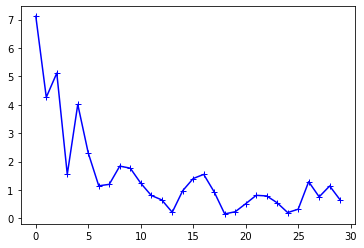

1.514803417523702
torch.Size([500, 100])
np.count_nonzero(output_relu)= 21412
sparsity 0.57176
Accuracy of the network on the 10000 test images: 94.79 %


In [23]:
def relu_diff(input1, input2):
    '''this is sparse: two level-relu'''
    return torch.max(input1 - input2, torch.zeros_like(input1))
    
class ReLU_my(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
        SiLU(x) = x * sigmoid(x)
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf
    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)
    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class
    
    def forward(self, input1, input2):
        '''
        Forward pass of the function.
        '''
        return relu_diff(input1, input2)

def weights_init(m):
    if type(m) == nn.Linear:
#         m.weight.data.normal_(0.0, 1)#93% accuracy for relu; 
#         m.weight.data.normal_(-1, 1)# 11% accuracy for relu; 93.62 for this idea. 
        m.weight.data.normal_(1, 1)#92.87
    
def weights_sparse(m):
    if isinstance(m, nn.Linear):
#         init.sparse_(m.weight.data, 0.3, 0.01)
#         init.sparse_(m.weight.data, 0.7, 0.01)
        init.sparse_(m.weight.data, 0.7, 0.1)
#         init.sparse_(m.weight.data, 0.7, 1.0)#worse
    
# print(np.random.binomial(1, 0.5, 5))

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(input_size, hidden_size) 
        self.relu = ReLU_my()
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = x
        
        out1 = self.fc1(out)
        out2 = self.fc2(out)
        
        out_relu = self.relu(out1, out2)
        out = self.fc3(out_relu)
        return out, out_relu  
#optionally add a sigmoid to the blocking; not sparse
#     def forward(self, x):
#         out = x
        
#         out1 = self.fc1(out)
#         out2 = self.fc2(out)
#         out2 = self.sigmoid(out2)
        
#         out_relu = self.relu(out1, out2)
#         out = self.fc3(out_relu)
#         return out, out_relu  

#now I can define my model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# model.apply(weights_init)
model.apply(weights_sparse)

#visualzing graphs
# writer=SummaryWriter('runs/experiment_1')
# dataiter=iter(train_loader)
# images, labels = dataiter.next()
# # print(images.shape)
# grid = torchvision.utils.make_grid(images)
# #writer.add_image('images', grid, 0)

# #images = images.reshape(-1, 28*28).to(device)
# dummy_input = torch.zeros(1, 28*28),
# writer.add_graph(model, dummy_input)
# writer.close()

start = time.time()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
losses=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs, _  = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            losses.append(loss.item())
            

print('elapsed: ', time.time()-start)
plt.plot(losses, '-b+')
plt.show()
print(np.mean(losses))

#check dead neurons
dataiter=iter(train_loader)
images, labels = dataiter.next()
images = images.reshape(-1, 28*28).to(device)
# print(images.shape)
A1 = images[:300]
# print(A1.shape)
output, output_relu = model(A1)

output_relu = output_relu.T.detach()
print(output_relu.shape)
# plt.plot(output_relu.numpy(), '-b+')
# plt.show()
print('np.count_nonzero(output_relu)=', np.count_nonzero(output_relu))
print('sparsity', 1- np.count_nonzero(output_relu)/ (output_relu.shape[0] * output_relu.shape[1]))


# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
labels_wrong = []
pred_wrong = []
img_wrong = []
with torch.no_grad():
    correct = 0
    total = 0
    for img, labels in test_loader:
#         print(img.shape)
        images = img.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        wrong_preds = (predicted != labels).numpy()
        wrong_index = []
        for (i, wrong) in enumerate(wrong_preds):
            if wrong:
                wrong_index.append(i) 
        if len(wrong_index) > 0:
            img_reshaped = img[wrong_index].numpy()[:,0,:,:]
            for img_w in range(img_reshaped.shape[0]):
                img_wrong.append(img_reshaped[img_w])
            labels_wrong  += (labels[wrong_index].numpy().tolist())
            pred_wrong += (predicted[wrong_index].numpy().tolist())
#     print(img_wrong)
#     print('img_wrong.shape', img_wrong[0].shape)
#     print('lables_wrong =', labels_wrong)
#     print('predictions wrong are:', pred_wrong)
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

#show wrong images:
# print(len(img_wrong), ', ', len(labels_wrong), ', ', len(pred_wrong))
# for i in range(len(img_wrong)):
#     plt.imshow(img_wrong[i])
#     print('labels_wrong[i]:', labels_wrong[i])
#     print('pred_wrong[i]', pred_wrong[i])
#     plt.pause(1)

# Save the model checkpoint
# torch.save(model.state_dict(), 'model.ckpt')


In [277]:
print('layer 1:')
w_fc1 = list(model.fc1.parameters())
print(w_fc1)

print('layer 2:')
w_fc2 = list(model.fc2.parameters())
print(w_fc2)

[Parameter containing:
tensor([[-0.5779,  0.0640,  0.1430, -0.1617, -0.5140,  0.3530,  0.5737, -0.1477,
          0.1958, -0.1691],
        [ 0.4743,  0.2682, -0.5371, -0.1988,  0.2150, -0.6793, -0.1516,  0.6180,
         -0.3148, -0.7621],
        [ 0.2593, -0.1268, -0.0784,  0.0650,  0.3511, -0.3761,  0.4965, -0.7066,
          0.4375, -0.4512],
        [-0.4706,  0.6136, -0.5341, -0.2328,  0.5161, -0.2980, -0.2179, -0.1023,
          0.1481,  0.2383],
        [ 0.0301, -0.7920,  0.7271, -0.2208,  0.5299,  0.3283, -0.6619, -0.1630,
         -0.1853, -0.2730],
        [-0.7178, -0.2460, -0.3829, -0.0773,  0.0664,  0.3904, -0.1010,  0.4212,
          0.1781,  0.1411],
        [ 0.1937, -0.3704,  0.1585, -0.1834, -0.6606,  0.0736, -0.4391,  0.3063,
          0.6534, -0.7792],
        [ 0.3262,  0.5748,  0.1930, -0.1342, -0.3776,  0.3556,  0.1013, -0.6247,
         -0.7301,  0.2556],
        [ 0.2724, -0.5699, -0.5487,  0.0173,  0.0711,  0.0028, -0.0344,  0.0607,
          0.2700,  0.423

Accuracy of the network on the 10000 test images: 97.12 %


In [ ]:
#future work
def relu_at(A, threshold):
    return torch.max(A, torch.ones_like(A) * threshold)

def relu_min_at(A, threshold):
    return torch.min(A, torch.ones_like(A) * threshold)

class ThresholdingNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ThresholdingNet2, self).__init__()
        self.maxlu = ReLU_my()
        self.minlu = ReLU_min()
        self.fc1 = nn.Linear(input_size*2, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = x
        
        out1 = self.maxlu(out)
        out2 = self.minlu(out)
        out = torch.cat((out1, out2), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out  
    
# model = ThresholdingNet(input_size, hidden_size, num_classes).to(device)
model = ThresholdingNet2(input_size, hidden_size, num_classes).to(device)